## Introduction

Natural Language Processing (NLP): The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

Sentiment Analysis: It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a Sentiment Analysis model to categorize a tweet as Positive or Negative.

# Table of Contents

1.Importing dependencies

2.Importing dataset

3.Preprocessing Text

4.Analysing data

5.Splitting data

6.TF-IDF Vectoriser

7.Transforming Dataset

8.Creating and Evaluating Models

9.Logistic Regression Model


# Importing Dependencies

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Importing dataset
The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]

It contains the following 6 fields:

1.sentiment: the polarity of the tweet (0 = negative, 4 = positive)

2.ids: The id of the tweet (2087)

3.date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4.flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5.user: the user that tweeted (robotickilldozr)

6.text: the text of the tweet (Lyx is cool)

We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

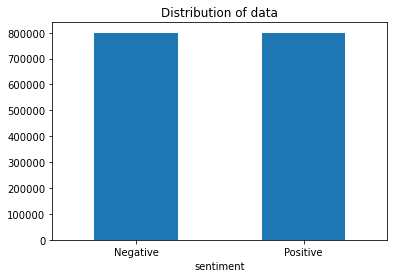

In [5]:
# Importing the dataset
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
encoding = "ISO-8859-1"
df = pd.read_csv('D:\\Internships\\CodeClause\\twitter_training.dataset.csv',
                      encoding=encoding , names=columns)

# Removing the unnecessary columns.
df = df[['sentiment','text']]

# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

# Preprocess Text¶

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase.

Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".

Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")

Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")

Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.

Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
Removing Short Words: Words with length less than 2 are removed.

Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")

Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [6]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\DASARI
[nltk_data]     NARSINGARAO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [11]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 100 seconds


# Analysing the data

Now we're going to analyse the preprocessed data to get an understanding of it.

We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

# Negative tweets.

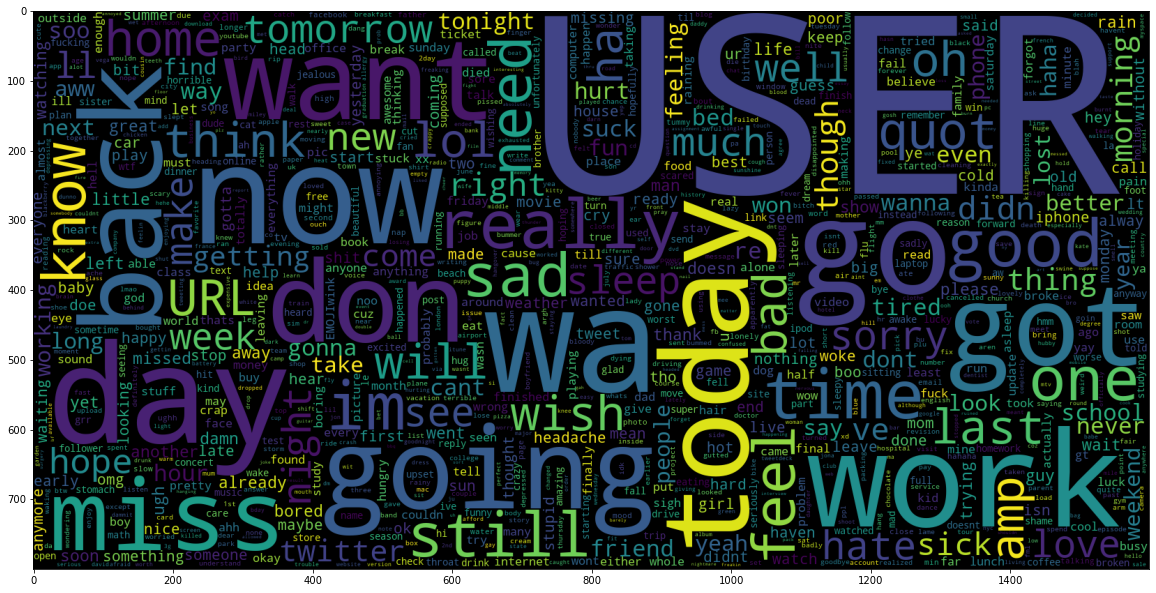

In [22]:
nagitive_tweets = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(nagitive_tweets))
plt.imshow(wc)

# Positive tweets.

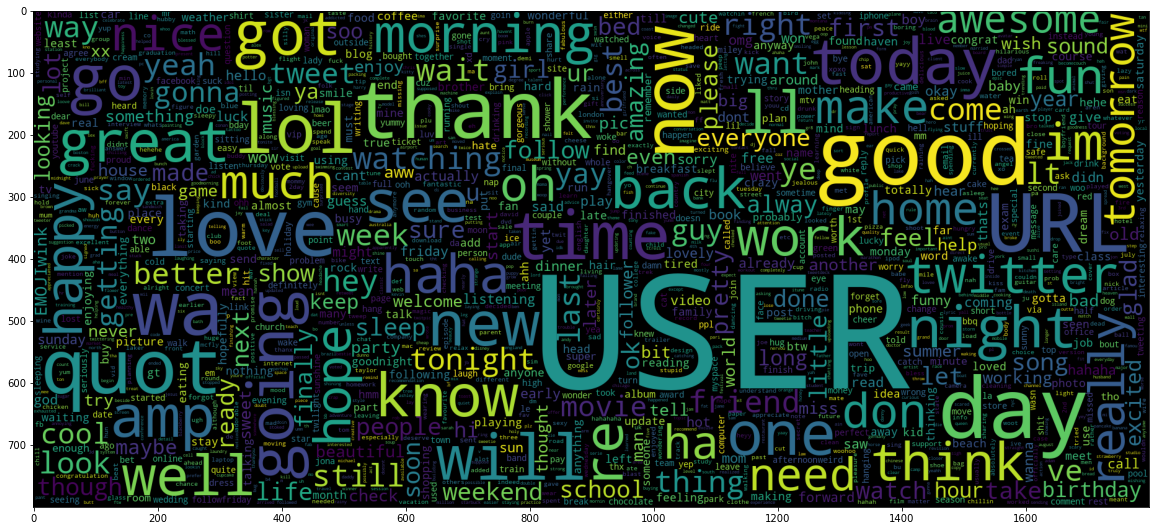

In [23]:
positive_tweets = processedtext[800000:]
wc = WordCloud(max_words = 1500 , width = 1800 , height = 800,
              collocations=False).generate(" ".join(positive_tweets))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting the Data

The Preprocessed Data is divided into 2 sets of data:

Training Data: The dataset upon which the model would be trained on. Contains 95% data.

Test Data: The dataset upon which the model would be tested against. Contains 5% data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)


# TF-IDF Vectoriser¶

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. 

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. 
The Vectoriser is usually trained on only the X_train dataset.

max_features specifies the number of features to consider.

In [16]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


## Tranforming the dataset
Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser.

This datasets will be used to train the model and test against it.

In [17]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)


## Creating and Evaluating Models

1.Logistic Regression (LR)

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. 
We're choosing Accuracy as our evaluation metric. Furthermore, we're plotting the Confusion Matrix to get an understanding of how our model is performing on both classification types.

In [18]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



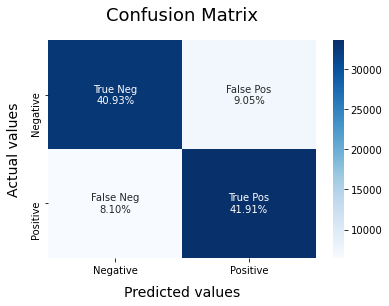

In [27]:
lrm = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lrm.fit(X_train, y_train)
model_Evaluate(lrm)


We can clearly see that the Logistic Regression Model performs the best  models that we tried. 
It achieves nearly 82% accuracy while classifying the sentiment of a tweet.